In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# Extra 
import wrf
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from xarrayMannKendall import compute_MK_trend_da
from plotter import draw_basemap, make_cmap, add_subregion_boxes
from timeseries import select_months_ds



In [2]:
# Set up paths

path_to_data = '/scratch1/08540/dlnash/data/'     # project data -- read only
path_to_data = '/work2/08540/dlnash/frontera/data/wrf_preprocessed_data/wrf_6km/' # WORK directory
path_to_data = '/home/nash/DATA/data/wrf_hasia/' # great
path_to_out  = '../out/'                          # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'                         # figures


In [3]:
ssn = "DJF" #"MAM" or "DJF"

if ssn == 'DJF':
    start_date = '1979-12-01'
    end_date = '2015-03-31'
    mon_s = 12
    mon_e = 2
    mon_lst = [12, 1, 2]
    plt_lst = ['(a) December', '(b) January', '(c) February']
    
if ssn == 'MAM':
    start_date = '1980-03-01'
    end_date = '2014-05-31'
    mon_s = 3
    mon_e = 5
    mon_lst = [3, 4, 5]
    plt_lst = ['(a) March', '(b) April', '(c) May']

lonmin = 61.
lonmax = 98.
latmin = 22.
latmax = 56.

# subregion info for ar type precip anomalies
ext1 = [69, 74, 37, 40] # Northwestern precip anomalies
ext2 = [71, 79, 32, 37] # Western precip anomalies
ext3 = [90, 99, 24, 30] # Eastern precip anomalies
domains = [ext1, ext2, ext3]
region_name = ['NW', 'W', 'E']

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []

for i, d in enumerate(domains):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))


### Load WRF data

In [4]:
# get terrain height from one wrf file
wrf_filename = "/work2/08540/dlnash/frontera/data/wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00"
wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

In [5]:
varname = 'ivt'
domain = 'd01'

filename_pattern = path_to_data + '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(domain, varname)
print(filename_pattern)
ds = xr.open_mfdataset(filename_pattern)
ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
ds


/home/nash/DATA/data/wrf_hasia/d01/ivt/daily/out.wrf6km.ivt.daily_*.nc


<xarray.Dataset>
Dimensions:  (time: 12906, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1979-11-30 1979-12-01 ... 2015-03-31
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    ivtu     (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>
    ivtv     (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>
    iwv      (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>
    ivt      (time, lat, lon) float64 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>

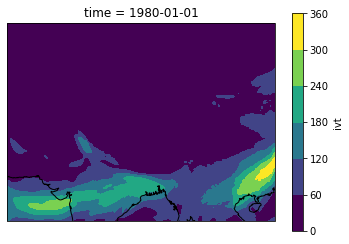

In [6]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

ds.ivt.sel(time='1980-01-01').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Average height of IVT during each month of winter season (climatology)

In [7]:
# get monthly climatology
ds_clim = ds.groupby("time.month").mean('time')
ds_clim

# get ssn clim
ssn_clim = ds_clim.sel(month=mon_lst).mean('month')
ssn_clim

<xarray.Dataset>
Dimensions:  (lat: 249, lon: 259)
Coordinates:
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    ivtu     (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>
    ivtv     (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>
    iwv      (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>
    ivt      (lat, lon) float64 dask.array<chunksize=(249, 259), meta=np.ndarray>

### Calculate Anomalies

In [8]:
%%time

## load filtered annual climatology
clim_mean = xr.open_dataset(path_to_data + 'd01/ivt/filtered_daily_mean_clim_ivt.nc')
clim_mean = clim_mean.assign(ivt=lambda clim_mean: np.sqrt(clim_mean.ivtu**2 + clim_mean.ivtv**2))

## Calculate Anomalies
anomalies_daily = ds.groupby('time.dayofyear') - clim_mean

# resample anomalies to monthly
anomalies_mon = anomalies_daily.resample(time="1MS").mean('time')

CPU times: user 51 s, sys: 44.3 s, total: 1min 35s
Wall time: 1min 35s


## Trend of IVT over AR days

### Load AR dates and merge with daily anomalies

In [9]:
filepath = path_to_out + 'AR-types_ALLDAYS.csv'
df = pd.read_csv(filepath)

# set times as index
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.set_index(pd.to_datetime(df['date']))

# select only ssn months
if mon_s > mon_e:
    idx = (df.index.month >= mon_s) | (df.index.month <= mon_e)
if mon_s < mon_e:
    idx = (df.index.month >= mon_s) & (df.index.month <= mon_e)
df = df.loc[idx]

# normalize datetimes to 00 UTC
df.index = df.index.strftime("%Y-%m-%d")

# set to days available in WRF
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]

# # select only ar days
idx = (df['AR_CAT'] > 0)
df = df.loc[idx]

# get list of dates that ar is present
ar_dates = pd.to_datetime(df.index).values
df

,date,AR_CAT
date,,
1979-12-01,1979-12-01 09:00:00,2
1979-12-02,1979-12-02 09:00:00,1
1979-12-08,1979-12-08 09:00:00,2
1979-12-09,1979-12-09 09:00:00,1
1979-12-16,1979-12-16 09:00:00,1
...,...,...
2015-02-23,2015-02-23 09:00:00,1
2015-02-24,2015-02-24 09:00:00,3
2015-02-25,2015-02-25 09:00:00,3


In [10]:
# subset non-anomalies to just ar days and calculate average
ar_ivt_daily = ds.sel(time = ar_dates)

# Combine AR Cat and ivt data w/ WRF data
colnames = ['AR_CAT']
for i, col in enumerate(colnames):
    ar_ivt_daily[col] = ('time', df[col])
    ar_ivt_daily = ar_ivt_daily.set_coords(col)
    
# compute climatology for AR types
ar_clim = ar_ivt_daily.groupby('AR_CAT').mean('time').compute()
    
# subset anomalies to just ar days
anomalies_daily = anomalies_daily.sel(time = ar_dates)

# Combine AR Cat and ivt data w/ WRF data
colnames = ['AR_CAT']
for i, col in enumerate(colnames):
    anomalies_daily[col] = ('time', df[col])
    anomalies_daily = anomalies_daily.set_coords(col)
    
anomalies_daily

<xarray.Dataset>
Dimensions:    (time: 1250, lat: 249, lon: 259)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2015-02-27
  * lat        (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon        (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    dayofyear  (time) int64 335 336 342 343 350 351 355 ... 52 53 54 55 56 57 58
    AR_CAT     (time) int64 2 1 2 1 1 3 1 1 1 3 2 1 ... 2 2 2 2 2 2 1 1 3 3 3 3
Data variables:
    ivtu       (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>
    ivtv       (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>
    iwv        (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>
    ivt        (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>

### Calculate Trends

In [11]:
%%time
final_trend_ivtu = []
final_trend_ivtv = []
final_trend_ivt = []
artype_lst = [2, 1, 3] # make it so the order is northwestern, western, eastern
for i, ar_type in enumerate(artype_lst):
    
    # ## select only type i ARs
    idx = (anomalies_daily.AR_CAT == ar_type)
    # select AR days
    ar_ds = anomalies_daily.sel(time=idx)
    
    ### resample to seasonal average
    ar_ssn = ar_ds.resample(time="QS-DEC", skipna=True).mean()
    
    # compute trend for all months - ivtu
    trend = compute_MK_trend_da(ar_ssn.ivtu)
    final_trend_ivtu.append(trend)
    
    # compute trend for all months - ivtv
    trend = compute_MK_trend_da(ar_ssn.ivtv)
    final_trend_ivtv.append(trend)
    
    # compute trend for all months - ivt
    trend = compute_MK_trend_da(ar_ssn.ivt)
    final_trend_ivt.append(trend)

CPU times: user 17min 38s, sys: 6min 41s, total: 24min 19s
Wall time: 18min 37s


In [12]:
ar_clim

<xarray.Dataset>
Dimensions:  (AR_CAT: 3, lat: 249, lon: 259)
Coordinates:
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
  * AR_CAT   (AR_CAT) int64 1 2 3
Data variables:
    ivtu     (AR_CAT, lat, lon) float64 -29.86 -30.19 -30.52 ... 8.809 8.935
    ivtv     (AR_CAT, lat, lon) float64 -17.25 -16.54 -16.16 ... -7.742 -7.672
    iwv      (AR_CAT, lat, lon) float64 19.7 19.62 19.54 ... 1.503 1.513 1.595
    ivt      (AR_CAT, lat, lon) float64 74.61 73.85 73.16 ... 15.19 14.89 14.98

### Plot trend for ssn broken down by AR type

In [13]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+5,5)
dy = np.arange(latmin,latmax+5,5)

# hack for tick labels
share_right = [False]*2 + [True]

13.347004505749712 -16.341413484805766
16.133905644838833 -11.931465174294106
15.776479066012755 -14.984124542704313


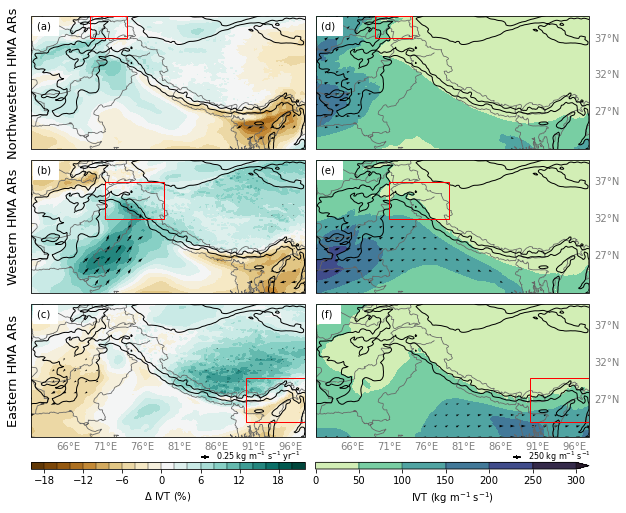

In [17]:
# hack for tick labels
share_bottom = [False]*2 + [True]
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
row_lbl = ['Northwestern HMA ARs', 'Western HMA ARs', 'Eastern HMA ARs']

# Create figure
fig = plt.figure(figsize=(10,13))
nrows = 3
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.15,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='column')

# Loop for drawing each plot
sr_idx = [0, 1, 2]
for k, ax in enumerate(axgr[0:nrows]):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=False, bottom_lons=share_bottom[k])
    # Data for plotting
    uvec = final_trend_ivtu[k]
    vvec = final_trend_ivtv[k]
    data = final_trend_ivt[k]
    lons = uvec.x.values
    lats = uvec.y.values
    
    sig_level = 0.1
    uvec_mask = uvec.trend.where((data.p <= sig_level)).values
    vvec_mask = vvec.trend.where((data.p <= sig_level)).values
    
    # Contour Filled
    cflevs = np.arange(-20, 24, 2)
    perc_change = ((data.trend.values*35)/ssn_clim.ivt.values)*100.
    print(np.nanmax(perc_change), np.nanmin(perc_change))
    cf = ax.contourf(lons, lats, perc_change, transform=datacrs,
                    levels=cflevs,cmap='BrBG', extend='neither')
    
    # # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=13, pivot='middle',
                  angles='xy', scale_units='xy', scale=0.25, units='xy')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
    # Subtitles
    ttl = "({0}) ".format(letter_lst[k])
    ax.text(0.02, 0.9625, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    # Row labels
    ax.text(-0.04, 0.5, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(r'$\Delta$ IVT (%)', fontsize=10)
cb.ax.tick_params(labelsize=10)

# quiver key
qk = ax.quiverkey(Q, 0.65, -0.15, 0.25, '0.25 kg m$^{-1}$ s$^{-1}$ yr$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})

# Loop for drawing each plot
arcat_lst = [2, 1, 3]
sr_idx = [0, 1, 2]
for k, ax in enumerate(axgr[nrows:]):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    # Data for plotting
    clim = ar_clim.sel(AR_CAT = arcat_lst[k])
    lons = clim.lon.values
    lats = clim.lat.values
    min_lvl = 100 # kg m-1 s-1
    uvec_mask = clim.ivtu.where((clim.ivt >= min_lvl)).values
    vvec_mask = clim.ivtv.where((clim.ivt >= min_lvl)).values
    
    # Contour Filled
    cflevs = np.arange(0, 350, 50)
    cf = ax.contourf(lons, lats, clim.ivt.values, transform=datacrs,
                    levels=cflevs,cmap=cmo.deep, extend='max')
    
    # # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=13, pivot='middle',
                  angles='xy', scale_units='xy', scale=250, units='xy')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
    # Subtitles
    ttl = "({0}) ".format(letter_lst[k+3])
    ax.text(0.02, 0.9625, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
cb.set_label(r'IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)

# quiver key
qk = ax.quiverkey(Q, 0.75, -0.15, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})
    
    
# Save figure
filepath = path_to_figs + 'ivt_AR_trend_{0}_portrait.png'.format(ssn)
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()